#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### CHAPTER 21
**CH20A Founder/family ownership and quality of management**

using the wms-management dataset
version 0.9 2020-09-11

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import sys
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/wms-management-survey/clean/"
data_out = dirname + "da_case_studies/ch21-ownership-management-quality/"
output = dirname + "da_case_studies/ch21-ownership-management-quality/output/"

func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions 
from py_helper_functions import *

### Read in data

In [4]:
data = pd.read_csv(data_out+"wms_da_textbook-work.csv")

In [5]:
data.groupby("foundfam_owned").mean()["management"]

foundfam_owned
0.0    3.055057
1.0    2.668851
Name: management, dtype: float64

### Set variables to use

In [6]:
y_var = "management"
x_var = "foundfam_owned"

control_vars = ["degree_nm", "degree_nm_sq", "compet_moder", "compet_strong", 
                  "lnemp", "age_young", "age_old", "age_unknown"]

control_vars_to_interact = ["industry", "countrycode"]

## REGRESSIONS

In [7]:
# OLS with no control vars.
formula1 = y_var + " ~ " + x_var
ols1 = smf.ols(formula=formula1, data=data).fit()

In [8]:
# OLS with all control vars
formula2 = (
    y_var + " ~ " + x_var + " + " + " + ".join(control_vars + control_vars_to_interact)
)
ols2 = smf.ols(formula=formula2, data=data).fit()

In [9]:
# OLS with all controls + interactions
formula3 = (
    y_var
    + " ~ "
    + x_var
    + "+"
    + ":".join(control_vars_to_interact)
    + "+("
    + "+".join(control_vars)
    + ")*("
    + "+".join(control_vars_to_interact)
    + ")"
)
ols3 = smf.ols(formula=formula3,data=data).fit()

In [10]:
stargazer = Stargazer([ols1, ols2, ols3])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer.custom_columns(
    ["'no confounders'", "'with confounders'", "'with confounders interacted'"],
    [1, 1, 1],
)
stargazer.show_model_numbers(False)
HTML(stargazer.render_html())

### EXACT MATCHING

In [11]:
data["management"].describe()

count    8666.000000
mean        2.880360
std         0.645775
min         1.000000
25%         2.444444
50%         2.888889
75%         3.333333
max         4.888889
Name: management, dtype: float64

In [12]:
data["empbin5"] = pd.cut(
    data["emp_firm"],
    bins=data["emp_firm"].quantile(np.arange(0, 1.01, 0.2)),
    include_lowest=True,
    right=False,
)
data["agecat"] = (
    (data["age_young"] == True)
    + 2 * (data["age_mid"] == True)
    + 3 * (data["age_old"] == True)
    + 4 * (data["age_unknown"] == True)
)

In [13]:
def functions_for_groupby(x):
    d = {}
    d["n"] = x["foundfam_owned"].count()
    d["n0"] = sum(1 - x["foundfam_owned"])
    d["n1"] = sum(x["foundfam_owned"])
    d["y0"] = sum(x["management"] * (x["foundfam_owned"] == 0))
    d["y1"] = sum(x["management"] * (x["foundfam_owned"] == 1))
    return pd.Series(d, index=["n", "n0", "n1", "y0", "y1"])

In [14]:
data_agg = (
    data.groupby(
        [
            "degree_nm_bins",
            "agecat",
            "competition",
            "empbin5",
            "industry",
            "countrycode",
        ]
    )
    .apply(functions_for_groupby)
    .reset_index()
)

data_agg = data_agg.loc[data_agg["n"].notnull()]
data_agg["y0"] = data_agg["y0"] / data_agg["n0"]
data_agg["y1"] = data_agg["y1"] / data_agg["n1"]

In [15]:
# firms with/without exact match
pd.Series(
    {
        "n0==0": data_agg.query("n0==0").shape[0],
        "n1==0": data_agg.query("n1==0").shape[0],
        "n0!=0 & n1!=0 ": data_agg.query("n0!=0 & n1!=0 ").shape[0],
    }
)

n0==0             2937
n1==0             3720
n0!=0 & n1!=0      479
dtype: int64

In [16]:
# random order just for the examples

In [17]:
np.random.seed(123)
data_sample = data_agg.sample(n=340)[
    [
        "industry",
        "countrycode",
        "degree_nm_bins",
        "competition",
        "agecat",
        "empbin5",
        "n1",
        "n0",
        "n",
    ]
]

In [18]:
# examples with founder/family only
data_sample.query("n1==1 & n0==0").head(8)

,industry,countrycode,degree_nm_bins,competition,agecat,empbin5,n1,n0,n
120831,primary_metal,mx,"[0.2, 1.01)",10+ competitors,1,"[120.0, 200.0)",1.0,0.0,1.0
89362,fabricated_metal,gr,"[0.05, 0.2)",1-4 competitors,2,"[120.0, 200.0)",1.0,0.0,1.0
66189,textile,sw,"[0.001, 0.05)",5-9 competitors,3,"[200.0, 350.0)",1.0,0.0,1.0
53495,instrument,us,"[0.001, 0.05)",10+ competitors,2,"[120.0, 200.0)",1.0,0.0,1.0
92674,chemical,gr,"[0.05, 0.2)",10+ competitors,2,"[350.0, 800.0)",1.0,0.0,1.0
32151,transport,mx,"[0.0, 0.001)",1-4 competitors,4,"[120.0, 200.0)",1.0,0.0,1.0
151109,rubber,cn,"[0.2, 1.01)",10+ competitors,4,"[800.0, 176000.0)",1.0,0.0,1.0
83101,electronic,it,"[0.05, 0.2)",10+ competitors,1,"[350.0, 800.0)",1.0,0.0,1.0


In [19]:
# examples with other only:
data_sample.query("n1==0 & n0==1").head(8)

,industry,countrycode,degree_nm_bins,competition,agecat,empbin5,n1,n0,n
47823,paper,mx,"[0.001, 0.05)",5-9 competitors,1,"[800.0, 176000.0)",0.0,1.0,1.0
25597,glass,it,"[0.0, 0.001)",10+ competitors,3,"[350.0, 800.0)",0.0,1.0,1.0
83308,misc_manuf,cl,"[0.05, 0.2)",10+ competitors,1,"[350.0, 800.0)",0.0,1.0,1.0
93577,transport,au,"[0.05, 0.2)",10+ competitors,2,"[800.0, 176000.0)",0.0,1.0,1.0
151852,ind_machinery,cl,"[0.2, 1.01)",5-9 competitors,4,"[120.0, 200.0)",0.0,1.0,1.0
47390,primary_metal,jp,"[0.001, 0.05)",5-9 competitors,1,"[350.0, 800.0)",0.0,1.0,1.0
131994,transport,po,"[0.2, 1.01)",10+ competitors,2,"[800.0, 176000.0)",0.0,1.0,1.0
139629,textile,sw,"[0.2, 1.01)",10+ competitors,3,"[1.0, 120.0)",0.0,1.0,1.0


In [20]:
# examples of similar firms unmatched
data_sample.query("countrycode == 'us' & industry == 'food' & n == 1")

,industry,countrycode,degree_nm_bins,competition,agecat,empbin5,n1,n0,n
85079,food,us,"[0.05, 0.2)",5-9 competitors,1,"[200.0, 350.0)",0.0,1.0,1.0
114839,food,us,"[0.05, 0.2)",5-9 competitors,4,"[800.0, 176000.0)",1.0,0.0,1.0
64439,food,us,"[0.001, 0.05)",10+ competitors,3,"[800.0, 176000.0)",0.0,1.0,1.0


In [21]:
# ATE/ATET by exact matching:
data_agg["y1-y0"] = data_agg["y1"] - data_agg["y0"]
pd.DataFrame.from_dict(
    {
        "ATE": np.average(
            data_agg.query("n0>0 & n1>0")["y1-y0"],
            weights=data_agg.query("n0>0 & n1>0")["n"],
        ),
        "ATET": np.average(
            data_agg.query("n0>0 & n1>0")["y1-y0"],
            weights=data_agg.query("n0>0 & n1>0")["n1"],
        ),
    },
    orient="index",
)

,0
ATE,-0.164453
ATET,-0.155871


## Matching on the propensity score 

In [40]:
# a súlyozást még meg kell csinálni, aztán WLS-t használni a végén, 
#plusz R-ben nem talált minden treatedhez matched controlt, itt pedig igen --> 
#a nearest neighbour searchet kell jól beállítani

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
data_pscore = data[[y_var] + [x_var] + control_vars + control_vars_to_interact].dropna()

In [25]:
data_pscore["industry"] = data_pscore["industry"].astype('category')
data_pscore["countrycode"] = data_pscore["countrycode"].astype('category')

In [26]:
formula_pscore1 = x_var + "~" + "+".join(control_vars + control_vars_to_interact)

In [27]:
log_reg = smf.logit(formula=formula_pscore1, data=data_pscore).fit()

Optimization terminated successfully.
         Current function value: 0.586872
         Iterations 6


In [28]:
pscore = log_reg.predict()

pos_pscore = pscore[data_pscore["foundfam_owned"] == 1]
neg_pscore = pscore[data_pscore["foundfam_owned"] == 0]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (3920,)
control count: (4746,)


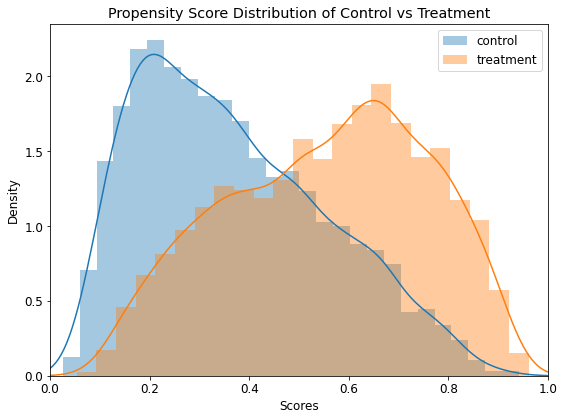

In [29]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[ 361],
       [2389],
       [4647],
       ...,
       [3635],
       [ 658],
       [ 295]])

In [31]:
index, counts = np.unique(sim_indices[:, 0], return_counts=True)

weights = pd.concat([pd.Series(index), pd.Series(counts)], axis=1)

In [32]:
data_pos = data_pscore[data_pscore["foundfam_owned"] == 1]
data_neg = data_pscore[data_pscore["foundfam_owned"] == 0].iloc[sim_indices[:, 0]]
data_neg["weight"] = (
    1.0 / pd.DataFrame(sim_indices[:, 0]).merge(weights, how="left", on=0)[1]
)

data_matched = pd.concat([data_pos, data_neg], axis=0)

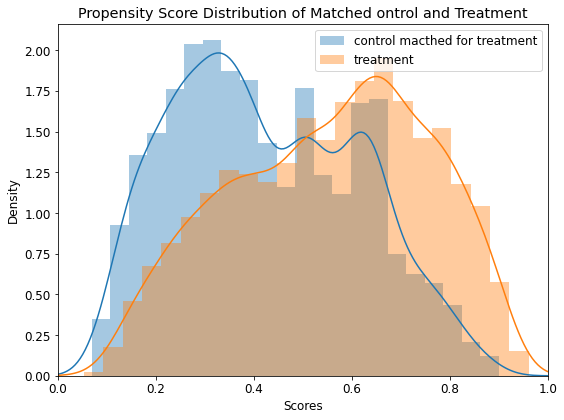

In [33]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(pscore[sim_indices[:, 0]], label='control macthed for treatment')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Matched ontrol and Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [36]:
reg_match = smf.ols(
    formula="management~foundfam_owned", data=data_matched
).fit()

In [37]:
reg_match.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             management   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     244.8
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           2.39e-54
Time:                        12:36:39   Log-Likelihood:                -7446.1
No. Observations:                7840   AIC:                         1.490e+04
Df Residuals:                    7838   BIC:                         1.491e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.8899      0.010    289.225      0.000       2.870       2.910
foundfam_owned    -0.2211      0.014    -15.645      0.000      -0.249      -0.193
==============================================================================
Omnibus:                       12.369   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.004
Skew:                           0.043   Prob(JB):                      0.00408
Kurtosis:                       2.838   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
formula_pscore2 = (
    x_var
    + " ~ "
    + "+"
    + ":".join(control_vars_to_interact)
    + "+("
    + "+".join(control_vars)
    + ")*("
    + "+".join(control_vars_to_interact)
    + ")"
)

In [39]:
log_reg2 = smf.logit(formula=formula_pscore2, data=data_pscore).fit()

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
pscore = log_reg.predict()

pos_pscore = pscore[data_pscore["foundfam_owned"] == 1]
neg_pscore = pscore[data_pscore["foundfam_owned"] == 0]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

In [ ]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()